# Clustering textual data into meaningful groups based on content similarity.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from sklearn.decomposition import NMF
from sklearn.cluster import AgglomerativeClustering
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
from sklearn.model_selection import GridSearchCV



In [3]:
# Download NLTK resources (if not already downloaded)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

print(nltk.download('punkt', quiet=True))
print(nltk.download('wordnet', quiet=True))
print(nltk.download('stopwords', quiet=True))
print(nltk.download('averaged_perceptron_tagger', quiet=True))

True
True
True
True


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
# Load data from Excel file (Replace 'data.xlsx' with your file path)
data = pd.read_excel(r"C:\Users\Hp\Downloads\data.xlsx")



In [5]:
# Select the column containing text data
ideas = data['Idea']


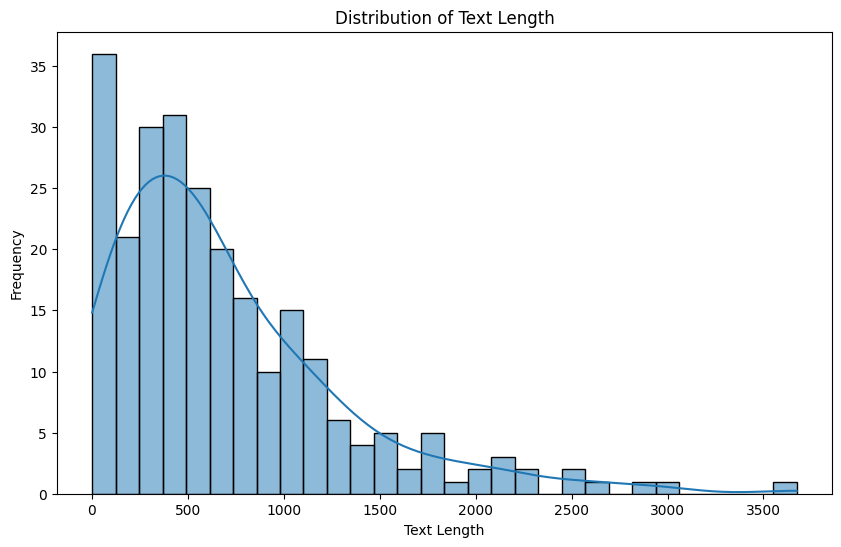

In [8]:
# Exploratory Data Analysis (EDA)
# Text Length Distribution
idea_length = ideas.str.len()
plt.figure(figsize=(10, 6))
sns.histplot(idea_length, bins=30, kde=True)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

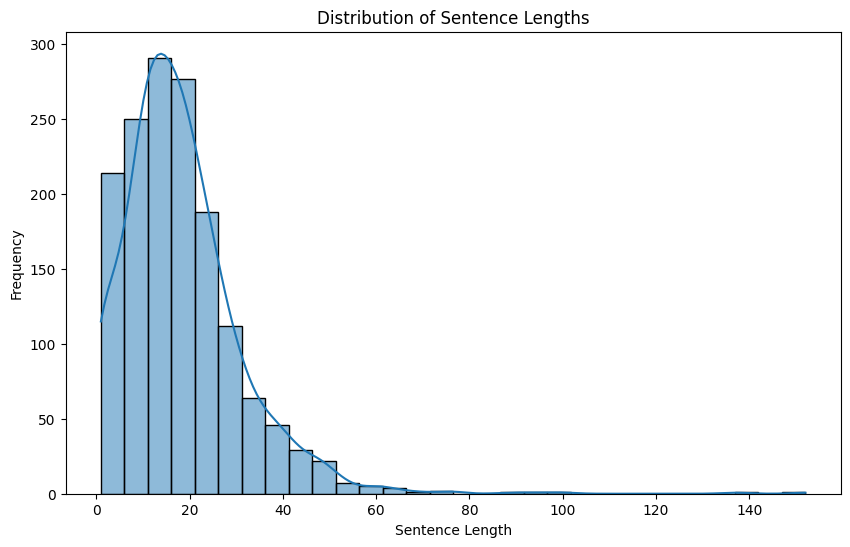

In [9]:
# Split the ideas into sentences
sentences = []
for idea in ideas:
    if isinstance(idea, str):
        for sent in idea.split('.'):
            if sent.strip():
                sentences.append(sent.strip())
    else:
        # Handle non-string values
        pass

# Calculate sentence lengths
sentence_lengths = [len(sent.split()) for sent in sentences]

# Plot the distribution of sentence lengths
plt.figure(figsize=(10, 6))
sns.histplot(sentence_lengths, bins=30, kde=True)
plt.title('Distribution of Sentence Lengths')
plt.xlabel('Sentence Length')
plt.ylabel('Frequency')
plt.show()


In [10]:
import spacy

# Load the English language model
nlp = spacy.load('en_core_web_sm')

# Perform NER on the ideas
ner_data = []
for idea in ideas:
    if isinstance(idea, str):
        doc = nlp(idea)
        ner_data.append([(ent.text, ent.label_) for ent in doc.ents])
    else:
        # Handle non-string values
        ner_data.append([])

# Print the named entities
print("Named Entities:")
for idea, entities in zip(ideas, ner_data):
    print(f"Idea: {idea}")
    print(f"Entities: {entities}")


Named Entities:
Idea: The idea is to create a ticketing support system wherein customer can log inquiry, concerns and support needed. Support system may include chat support for real-time customer experience.

This type of system can help the company to track each ticket raised by support team (from chat facility)/direct from customer, with this functionality company can trace easily which customer requires higher attention based on the issue logged in the system.

Notes can be added easily within the customer record to help all the people within Boots to have same/sync information.

Automatic alerts for concerns or ticket that have been long standing can also be added so full attention from the management be allocated which can avoid irate clients/customer.

Entities: [('Notes', 'PRODUCT'), ('Boots', 'WORK_OF_ART')]
Idea: Level 1  -  Integrate Machine Learning Algorithms which uses NLP and Pattern recognition to identity the user problem and provide solutions instantaneously (through 

In [13]:
# Revised text preprocessing function
def preprocess_text(text):
    text = str(text).lower()  # Convert text to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove non-word characters
    tokens = word_tokenize(text)  # Tokenize text

    # Consider keeping more common words like "user" and "data"
    stop_words = set(stopwords.words('english')) - {'user', 'data'}
    custom_stop_words = {'include', 'custom', 'stop', 'words', 'list', 'specific', 'dataset', 'filter', 'irrelevant'}
    stop_words.update(custom_stop_words)

    # Part-of-speech tagging with expanded categories
    tagged_tokens = nltk.pos_tag(tokens)

    # Filter tokens based on POS tags (keep nouns, verbs, adjectives, adverbs)
    filtered_tokens = [token for token, pos in tagged_tokens
                        if pos.startswith('N') or pos.startswith('V') or pos.startswith('J') or pos.startswith('R')]

    # Lemmatization (or stemming if preferred)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]

    processed_text = ' '.join(lemmatized_tokens)
    return processed_text


In [14]:
# Text Preprocessing
corpus = [preprocess_text(text) for text in ideas]


In [16]:
from collections import Counter

# Count the frequency of words
word_counts = Counter(" ".join(corpus).split())



In [17]:
# Print the top 10 most frequent words
print("Top 10 Most Frequent Words:")
for word, count in word_counts.most_common(10):
    print(f"{word}: {count}")


Top 10 Most Frequent Words:
be: 395
is: 338
user: 178
customer: 175
data: 157
system: 151
product: 138
based: 134
are: 133
ticket: 129


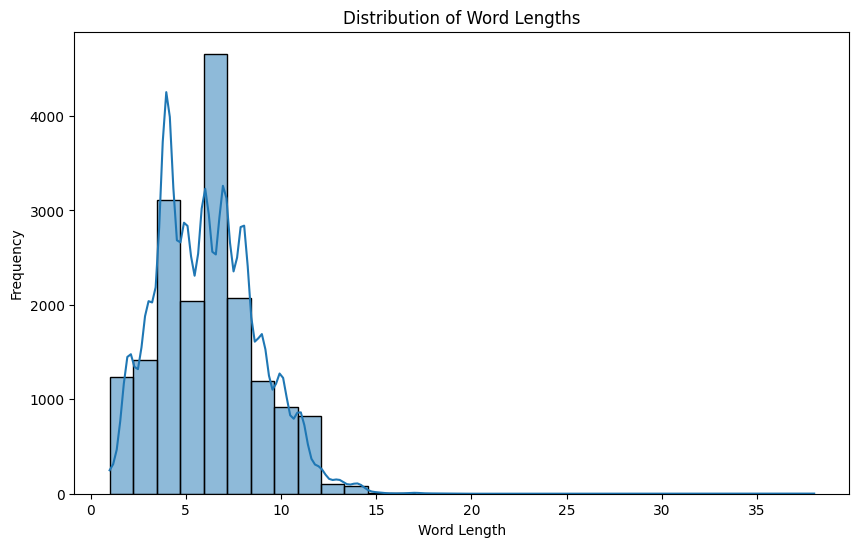

In [18]:
# Calculate word lengths
word_lengths = [len(word) for idea in corpus for word in idea.split()]

# Plot the distribution of word lengths
plt.figure(figsize=(10, 6))
sns.histplot(word_lengths, bins=30, kde=True)
plt.title('Distribution of Word Lengths')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.show()


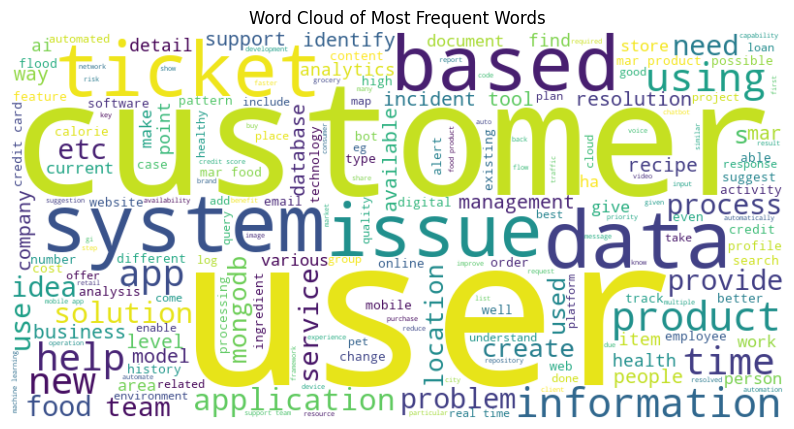

In [19]:
# Word Cloud of Most Frequent Words
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(corpus))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.show()

In [20]:
# Revised TF-IDF vectorization
vectorizer = TfidfVectorizer(ngram_range=(1, 3), use_idf=True, sublinear_tf=True, norm='l2')
tfidf_matrix = vectorizer.fit_transform(corpus)



In [21]:
# Revised dimensionality reduction using NMF
nmf = NMF(n_components=2, random_state=42)
tfidf_nmf = nmf.fit_transform(tfidf_matrix)


In [91]:
# Revised clustering using Hierarchical Clustering
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters=2, linkage='ward')
clusters = hc.fit_predict(tfidf_nmf)


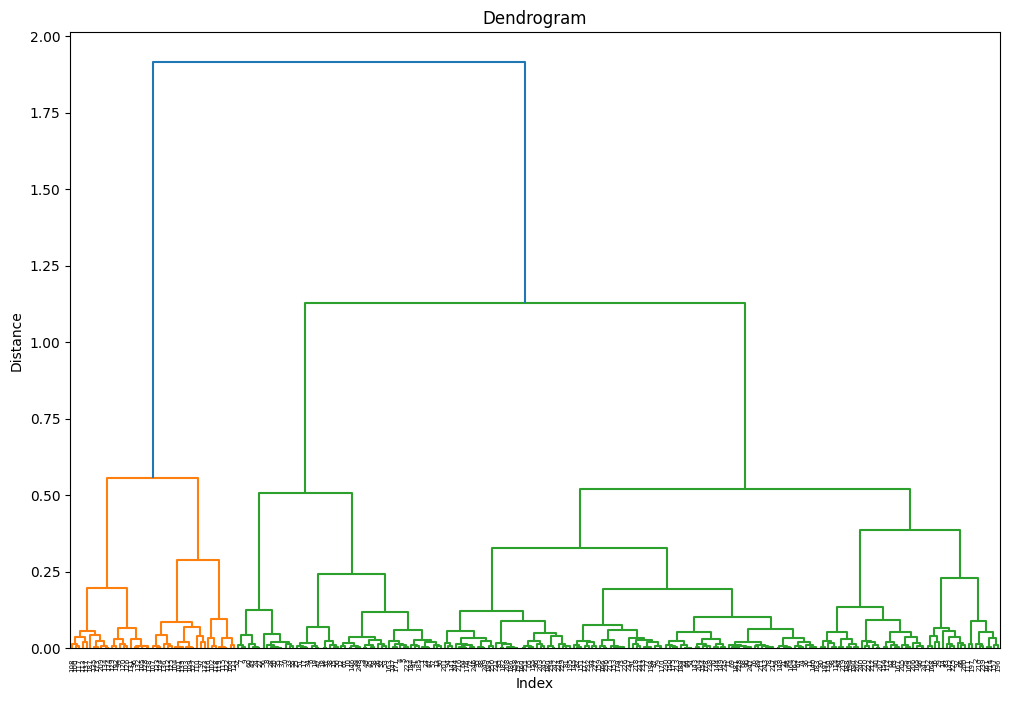

In [95]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage

# Assuming you have already performed the TF-IDF and NMF steps
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(corpus)
nmf = NMF(n_components=2, random_state=42)
tfidf_nmf = nmf.fit_transform(tfidf_matrix)

# Revised clustering using Hierarchical Clustering
hc = AgglomerativeClustering(n_clusters=2, linkage='ward')
clusters = hc.fit_predict(tfidf_nmf)

# Get the linkage matrix
linkage_matrix = linkage(tfidf_nmf, method='ward')

# Visualize the dendrogram
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, orientation='top')
plt.title("Dendrogram")
plt.xlabel("Index")
plt.ylabel("Distance")
plt.show()


In [23]:
# Analyze top words per cluster using TF-IDF scores
top_words_per_cluster = {}
feature_names = vectorizer.get_feature_names_out()

for cluster_id in range(hc.n_clusters):
    top_words_per_cluster[cluster_id] = []
    cluster_tfidf = tfidf_matrix[clusters == cluster_id]
    cluster_tfidf_mean = np.array(cluster_tfidf.mean(axis=0)).squeeze()
    top_feature_indices = np.argsort(cluster_tfidf_mean)[::-1][:10]

    for feature_idx in top_feature_indices:
        word = feature_names[feature_idx]
        score = cluster_tfidf_mean[feature_idx]
        top_words_per_cluster[cluster_id].append((word, score))


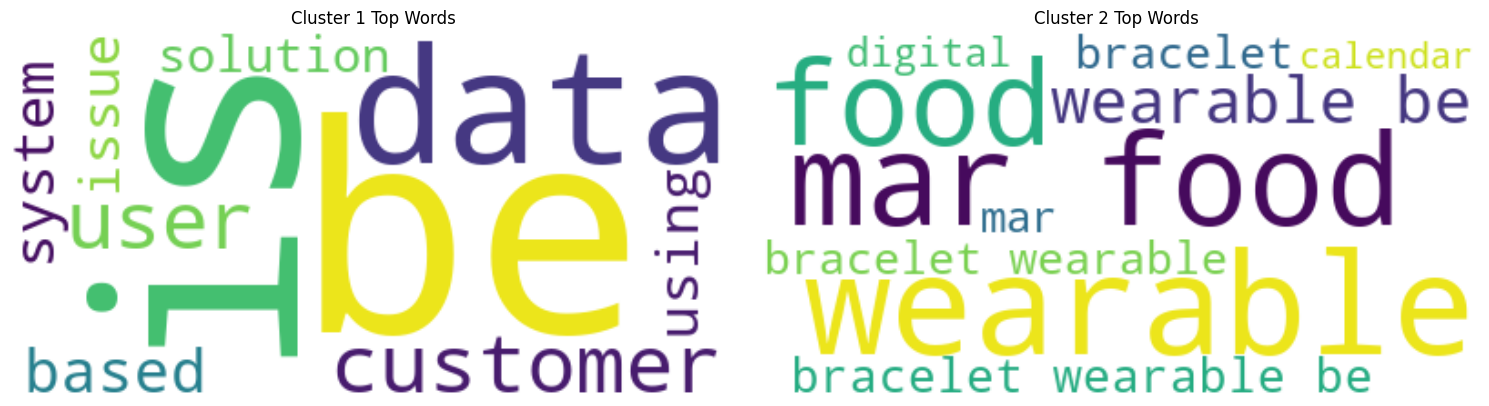

In [24]:
# Plot word clouds for the top words per cluster
def plot_word_clouds(top_words_per_cluster):
    num_clusters = len(top_words_per_cluster)

    # Create subplots for each cluster
    fig, axs = plt.subplots(1, num_clusters, figsize=(15, 5), squeeze=False)
    for cluster_id, top_words in top_words_per_cluster.items():
        # Convert top words list to a dictionary for WordCloud input
        wordcloud_dict = {word: score for word, score in top_words}

        # Generate WordCloud for the current cluster
        wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(wordcloud_dict)

        # Plot WordCloud in the corresponding subplot
        axs[0, cluster_id].imshow(wordcloud, interpolation='bilinear')
        axs[0, cluster_id].set_title(f'Cluster {cluster_id + 1} Top Words')
        axs[0, cluster_id].axis('off')

    plt.tight_layout()
    plt.show()

plot_word_clouds(top_words_per_cluster)


In [25]:
# Evaluate clustering performance for Hierarchical Clustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

silhouette_avg = silhouette_score(tfidf_nmf, clusters)
davies_bouldin_index = davies_bouldin_score(tfidf_nmf, clusters)

print(f"Silhouette Score: {silhouette_avg}")
print(f"Davies-Bouldin Index: {davies_bouldin_index}")


Silhouette Score: 0.9369054044186182
Davies-Bouldin Index: 0.11319559113078133


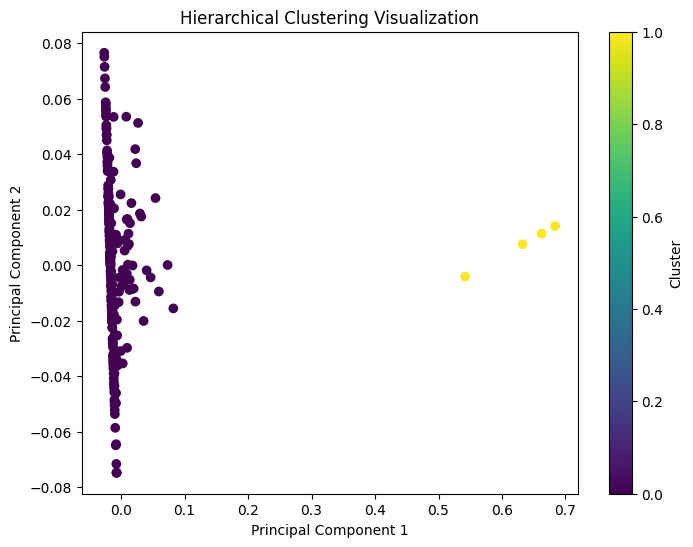

Number of Clusters: 2

Top Words per Cluster:
Cluster 1:
- be (0.0188)
- is (0.0174)
- data (0.0140)
- customer (0.0130)
- user (0.0126)
- based (0.0122)
- system (0.0118)
- using (0.0114)
- issue (0.0106)
- solution (0.0104)
Cluster 2:
- wearable (0.1173)
- mar food (0.0968)
- food (0.0834)
- wearable be (0.0824)
- bracelet wearable be (0.0784)
- bracelet wearable (0.0784)
- bracelet (0.0784)
- mar (0.0695)
- digital (0.0615)
- calendar (0.0613)


In [26]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Visualize the clusters
plt.figure(figsize=(8, 6))
pca = PCA(n_components=2)
tfidf_nmf_pca = pca.fit_transform(tfidf_nmf)
plt.scatter(tfidf_nmf_pca[:, 0], tfidf_nmf_pca[:, 1], c=clusters, cmap='viridis')
plt.title('Hierarchical Clustering Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.show()

# Print the number of clusters
print(f"Number of Clusters: {hc.n_clusters}")

# Print the top words per cluster
print("\nTop Words per Cluster:")
for cluster_id, top_words in top_words_per_cluster.items():
    print(f"Cluster {cluster_id+1}:")
    for word, score in top_words:
        print(f"- {word} ({score:.4f})")


In [29]:
from sklearn.decomposition import LatentDirichletAllocation

# Step 3: Define the number of topics for LDA
num_topics = 2  # Adjust the number of topics based on your data

# Step 4: Train LDA model on TF-IDF matrix
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_matrix = lda.fit_transform(tfidf_matrix)  # tfidf_matrix is your TF-IDF matrix

# Step 5: Interpret and display the topics
feature_names = vectorizer.get_feature_names_out()

print("Top words per topic:")
for topic_idx, topic in enumerate(lda.components_):
    top_words_indices = topic.argsort()[:-10 - 1:-1]  # Get indices of top 10 words
    top_words = [feature_names[i] for i in top_words_indices]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")



Top words per topic:
Topic 1: be, is, food, user, blockchain, based, product, app, mar, are
Topic 2: be, data, is, customer, using, system, user, based, issue, credit


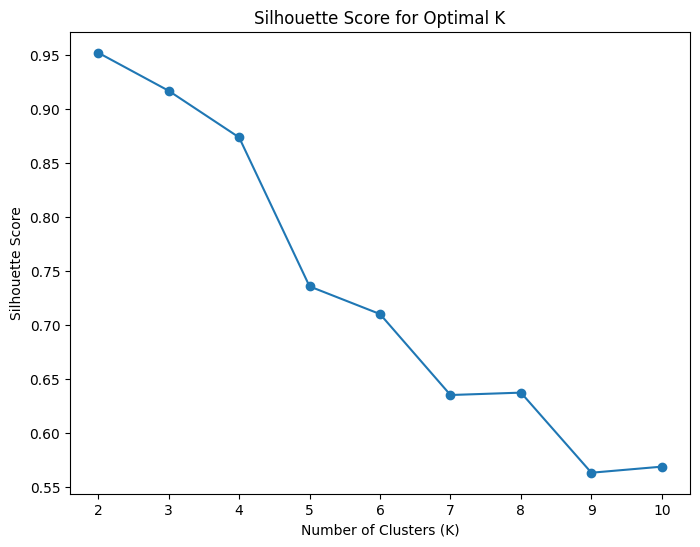

In [41]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Initialize lists to store silhouette scores
silhouette_scores = []
k_values = range(2, 11)  # Range of k values to evaluate

# Calculate silhouette score for each value of k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(lda_matrix)
    silhouette_avg = silhouette_score(lda_matrix, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plotting the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_values)
plt.show()


In [42]:
from sklearn.cluster import KMeans

# Define the number of clusters
n_clusters = 3

# Perform K-means clustering on LDA topic distribution matrix
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)

cluster_labels = kmeans.fit_predict(lda_matrix)


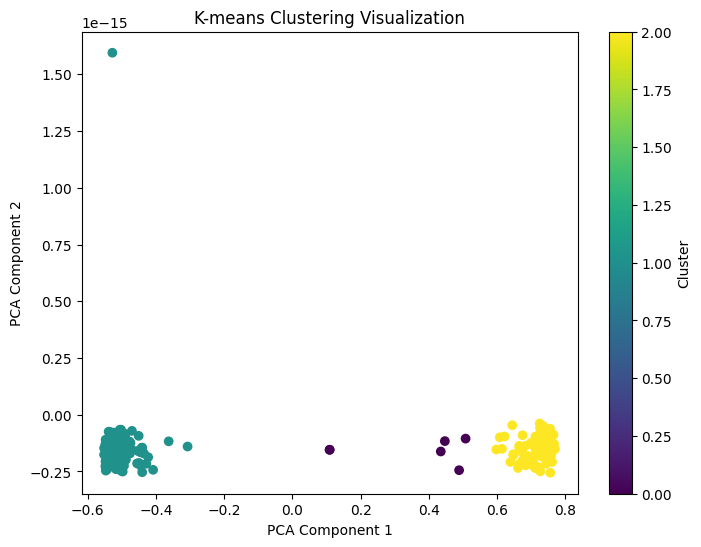

In [43]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensionality for visualization (example using PCA)
pca = PCA(n_components=2)
lda_matrix_pca = pca.fit_transform(lda_matrix)

# Plot clusters in 2D space
plt.figure(figsize=(8, 6))
plt.scatter(lda_matrix_pca[:, 0], lda_matrix_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.title('K-means Clustering Visualization')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()


In [44]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Compute Silhouette score
silhouette_avg = silhouette_score(lda_matrix, cluster_labels)
print(f"Silhouette Score: {silhouette_avg}")

# Compute Davies-Bouldin index
db_index = davies_bouldin_score(lda_matrix, cluster_labels)
print(f"Davies-Bouldin Index: {db_index}")


Silhouette Score: 0.9168728662614356
Davies-Bouldin Index: 0.40918401355627926


In [45]:
# Analyze cluster contents
clusters = {}
for cluster_id in range(n_clusters):
    cluster_docs = np.where(cluster_labels == cluster_id)[0]
    clusters[cluster_id] = cluster_docs.tolist()
    print(f"Cluster {cluster_id}: {len(cluster_docs)} documents")

    # Print example documents from each cluster
    if len(cluster_docs) > 0:
        print(f"Example Document from Cluster {cluster_id}:")
        print(corpus[cluster_docs[0]])  # Print first document in the cluster


Cluster 0: 6 documents
Example Document from Cluster 0:

Cluster 1: 146 documents
Example Document from Cluster 1:
idea is create ticketing support system customer log inquiry concern support needed support system include chat support real time customer experience type system help company track ticket raised support team facility direct customer functionality company trace easily customer requires higher attention based issue logged system note be added easily customer record help people boot have same sync information automatic alert concern ticket have been long standing also be added so full attention management be allocated avoid irate client customer
Cluster 2: 100 documents
Example Document from Cluster 2:
level integrate machine learning algorithm us nlp pattern recognition identity user problem provide solution instantaneously visual representation centralized knowledge management repository level above algorithm fails identify pattern problem use additional algorithm identify 

In [46]:
import numpy as np

# Assuming lda_matrix contains the LDA topic distribution matrix
# and cluster_labels contains the cluster labels assigned by K-means

# Define the number of clusters and topics
n_clusters = 3
n_topics = lda_matrix.shape[1]  # Number of topics in the LDA model

# Initialize an array to store dominant topics for each cluster
cluster_topics = np.zeros(n_clusters, dtype=int)

# Calculate mean topic distribution for each cluster
for cluster_id in range(n_clusters):
    # Get indices of documents belonging to the current cluster
    cluster_indices = np.where(cluster_labels == cluster_id)[0]

    if len(cluster_indices) > 0:
        # Extract topic distributions of documents in the current cluster
        cluster_topic_distributions = lda_matrix[cluster_indices, :]

        # Calculate mean topic distribution across all documents in the cluster
        mean_topic_distribution = np.mean(cluster_topic_distributions, axis=0)

        # Identify the dominant topic (topic with the highest mean probability)
        dominant_topic = np.argmax(mean_topic_distribution)
        cluster_topics[cluster_id] = dominant_topic

# Print cluster ID -> dominant topic ID mapping
print("Cluster ID -> Dominant Topic ID:")
for cluster_id, dominant_topic_id in enumerate(cluster_topics):
    print(f"Cluster {cluster_id}: Dominant Topic {dominant_topic_id}")


Cluster ID -> Dominant Topic ID:
Cluster 0: Dominant Topic 0
Cluster 1: Dominant Topic 1
Cluster 2: Dominant Topic 0


In [47]:
# Assuming lda_model is your trained LDA model and feature_names are the vectorizer's feature names
# Extract top words for each topic from the LDA model
def get_top_words(lda_model, feature_names, n_top_words=10):
    top_words = []
    for topic_idx, topic in enumerate(lda_model.components_):
        # Get indices of top words for the current topic
        top_word_indices = topic.argsort()[:-n_top_words - 1:-1]
        # Get the actual words corresponding to the top indices
        top_topic_words = [feature_names[i] for i in top_word_indices]
        top_words.append(top_topic_words)
    return top_words

# Get the top words for each topic in the LDA model
n_top_words = 10  # Number of top words to display for each topic
top_words_per_topic = get_top_words(lda, feature_names, n_top_words)

# Print the top words for each topic
for topic_idx, top_words in enumerate(top_words_per_topic):
    print(f"Topic {topic_idx}:")
    print(", ".join(top_words))
    print()  # Print a blank line for separation


Topic 0:
be, is, food, user, blockchain, based, product, app, mar, are

Topic 1:
be, data, is, customer, using, system, user, based, issue, credit

